In [1]:
#!pip3 install mesa

In [2]:
# https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html
# https://mesa.readthedocs.io/en/latest/tutorials/adv_tutorial.html

In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
from mesa.visualization.modules import ChartModule
from mesa.space import MultiGrid

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.batchrunner import BatchRunner

from time import asctime
from random import random

import pandas as pd
import numpy as np

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

# For a jupyter notebook add the following line:
%matplotlib inline

In [4]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model, verbose=True):
        super().__init__(unique_id, model)
        self.wealth = 1
        self.verbose = verbose

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        if self.verbose:
            print("Hi, I am agent " + str(self.unique_id) + ".")
            print("I have a wealth of {}.".format(str(self.wealth))) # Ex 1
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        if self.verbose:
            print("giving away wealth") #{}".format(other_agent)) # Ex 1
        other_agent.wealth += 1
        self.wealth -= 1
        if self.verbose:
            print("Now, I have a wealth of {}.".format(str(self.wealth))) # Ex 1


In [5]:
class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height, verbose=True):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True # added later
        self.verbose=verbose

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self, self.verbose)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
#            self.grid = MultiGrid(10, 10, torus=True)

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
### Ex 1
# Try modifying the code above to have every agent print out 
# its wealth when it is activated. Run a few steps of the model
# to see how the agent activation order is shuffled each step.

In [7]:
UID = asctime().replace(":", "").replace(" ", "")+str(random()).replace(".", "")

In [8]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

In [9]:
#from money_model import MoneyModel
empty_model = MoneyModel(10, 3, 2, False)
empty_model.step()

In [10]:
model = MoneyModel(5, 3, 2, False)
for i in range(5):
    model.step()

(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

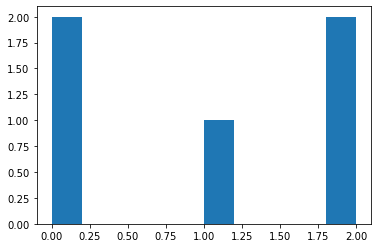

In [11]:
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

In [12]:
plt.show()

(array([428., 315., 154.,  56.,  31.,  12.,   4.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <BarContainer object of 7 artists>)

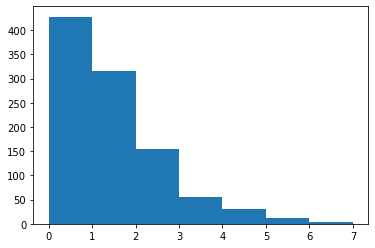

In [13]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10, 3, 2, False)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))

In [14]:
model = MoneyModel(50, 10, 10, False)
for i in range(20):
    model.step()

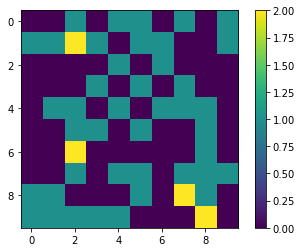

In [15]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

plt.show()

In [16]:
model = MoneyModel(50, 10, 10, False)
for i in range(100):
    model.step()

<AxesSubplot:>

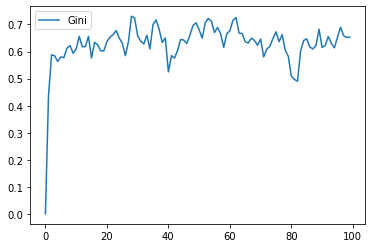

In [17]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [18]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

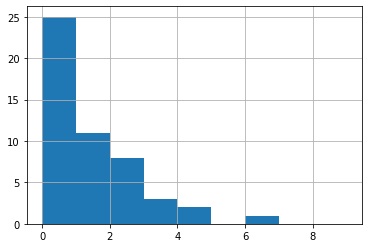

In [19]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

<AxesSubplot:xlabel='Step'>

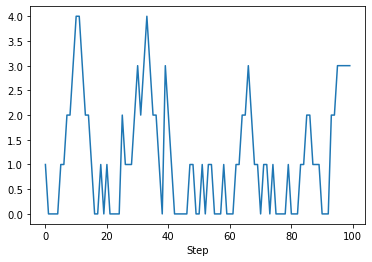

In [20]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [21]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV.
agent_wealth.to_csv("agent_data.csv")

In [22]:
params = {"width": 10, "height": 10, "N": range(10, 500, 10), "verbose": False}

results = batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

1225it [08:37,  2.37it/s]


In [23]:
results_df = pd.DataFrame(results)

In [24]:
print(results_df.keys())
#Index(['AgentID', 'Gini', 'N', 'RunId', 'Step', 'Wealth', 'height',
#       'iteration', 'width'],
#      dtype='object')

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'verbose', 'Gini',
       'AgentID', 'Wealth'],
      dtype='object')


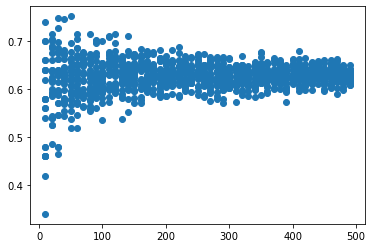

In [25]:
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(N_values, gini_values)

In [26]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]

# Then, print the columns of interest of the filtered data frame
#print(one_episode_wealth.to_string(index=False, columns=["Step", "AgentID", "Wealth"]))

# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter Notebook
# from IPython.display import display, HTML
# display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

In [27]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]

print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    1  0.42
    2  0.54
    3  0.54
    4  0.54
    5  0.58
    6  0.62
    7  0.58
    8  0.42
    9  0.48
   10  0.62
   11  0.66
  ...   ...
   89  0.58
   90  0.58
   91  0.64
   92  0.48
   93  0.42
   94  0.54
   95  0.46
   96  0.48
   97  0.46
   98  0.34
   99  0.42
  100  0.46


In [28]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

In [29]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8522 # The default

server.launch()

Interface starting at http://127.0.0.1:8522


RuntimeError: This event loop is already running